In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

from EVO import LogisticRegression, EvolutionOptimizer



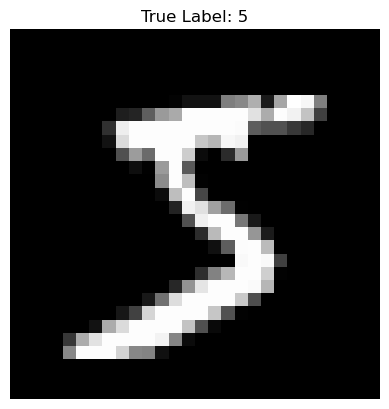

X_train_exp shape: torch.Size([60000, 7850])


In [4]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define a transform that converts images to a tensor and flattens them.
transform = transforms.Compose([
    transforms.ToTensor(),                    # MNIST images are [1, 28, 28]
    transforms.Lambda(lambda x: x.view(-1))     # Flatten to [784]
])

# Load the MNIST training and test sets.
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def add_bias(X):
    # X is of shape (N, 784), append a column of ones to yield shape (N, 785)
    N = X.size(0)
    bias = torch.ones(N, 1)
    return torch.cat([X, bias], dim=1)

# Build full training tensors.
X_train = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
X_train = add_bias(X_train)  # Now shape: (N_train, 785)
y_train = torch.tensor([train_dataset[i][1] for i in range(len(train_dataset))])

# Build full test tensors.
X_test = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
X_test = add_bias(X_test)   # Now shape: (N_test, 785)
y_test = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))])

def expand_features(X, num_classes=10):
    """
    Expand features from shape (N, d) to (N, d * num_classes) by forming blocks.
    Here we multiply each block by a unique constant so that each block is distinct.
    """
    N, d = X.shape
    blocks = []
    for c in range(num_classes):
        # Multiply the original features by (c+1)
        blocks.append( (c+1) * X )
    return torch.cat(blocks, dim=1)

# Expand the feature matrices so that each sample now has 7850 features.
X_train_exp = expand_features(X_train, num_classes=10)  # shape: (N_train, 7850)
X_test_exp  = expand_features(X_test, num_classes=10)   # shape: (N_test, 7850)

# (Optional) Visualize one original image.
img = X_train[0][:-1].view(28, 28)  # exclude bias from visualization
plt.imshow(img, cmap='gray')
plt.title(f"True Label: {y_train[0].item()}")
plt.axis('off')
plt.show()

print("X_train_exp shape:", X_train_exp.shape)  # Should be (N_train, 7850)

In [19]:
import torch
import torch.nn.functional as F

class MultiClassLogisticRegressionWrapper:
    def __init__(self, input_dim=785, num_classes=10, device=torch.device("cpu")):
        """
        :param input_dim: the original feature dimension (e.g. 785 = 784 pixels + bias)
        :param num_classes: number of classes (e.g. 10 for MNIST)
        :param device: device on which to perform computations (e.g. mps, cuda, or cpu)
        """
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.device = device
        self.w = None  # This will be a flat weight vector of length input_dim * num_classes.
        self.population = []  # For the evolutionary optimizer

    def score_with(self, X_exp, w):
        """
        Compute the per-class scores using candidate weight vector w.
        :param X_exp: Expanded feature matrix of shape (N, input_dim * num_classes)
        :param w: Candidate flat weight vector of shape (input_dim * num_classes,)
        :return: Tensor of scores of shape (N, num_classes)
        """
        # Move X_exp to the proper device.
        X_exp = X_exp.to(self.device)
        # Reshape candidate weight vector into a (input_dim, num_classes) matrix.
        W = w.view(self.input_dim, self.num_classes)
        N = X_exp.size(0)
        # Reshape X_exp into (N, num_classes, input_dim). That is, each sample has num_classes blocks.
        X_chunks = X_exp.view(N, self.num_classes, self.input_dim)
        scores = []
        for c in range(self.num_classes):
            X_c = X_chunks[:, c, :]    # shape: (N, input_dim)
            W_c = W[:, c]              # shape: (input_dim,)
            # Compute the inner product for class c.
            score_c = (X_c * W_c).sum(dim=1)  # (N,)
            scores.append(score_c)
        # Stack scores to form (N, num_classes)
        return torch.stack(scores, dim=1)

    def score(self, X_exp):
        """
        Compute scores using the currently stored weight vector (self.w).
        """
        if self.w is None:
            # Initialize self.w if not yet initialized.
            self.w = torch.rand(self.input_dim * self.num_classes, device=self.device)
        return self.score_with(X_exp, self.w)

    def predict(self, X_exp):
        """
        Predict the class (as an integer between 0 and num_classes-1)
        """
        scores = self.score(X_exp)
        return torch.argmax(scores, dim=1)

    def loss(self, X_exp, y, w=None, diversity_weight=0.5):
        """
        Compute the cross-entropy loss for candidate weight vector w (or self.w if w is None),
        using the expanded feature matrix X_exp and the integer label vector y.
        Additionally, add a diversity term to encourage diverse solutions.
        :param diversity_weight: Weight for the diversity term in the loss.
        """
        if w is None:
            w = self.w
        # Ensure the candidate is on the correct device.
        w = w.to(self.device)
        # Compute scores using the candidate w.
        scores = self.score_with(X_exp, w)
        ce_loss = F.cross_entropy(scores, y)

        # Compute diversity term based on pairwise distances in the population.
        diversity_term = 0
        if self.population:
            for candidate in self.population:
                diversity_term += torch.norm(w - candidate)
            diversity_term /= len(self.population)

        # Combine cross-entropy loss with diversity term.
        total_loss = ce_loss - diversity_weight * diversity_term
        return total_loss

In [21]:
import torch

# Choose device: use MPS if available (Apple Silicon), else CPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model on the chosen device.
model = MultiClassLogisticRegressionWrapper(input_dim=785, num_classes=10, device=device)

# Import your EvolutionOptimizer from EVO.py (unchanged).
from EVO import EvolutionOptimizer

# Instantiate the evolutionary optimizer.
optimizer = EvolutionOptimizer(model)
optimizer.set_population_size(40)
optimizer.set_mutation_rate(0.8)
optimizer.set_mutation_intensity(1)

# Ensure your expanded training data is on the same device.
X_train_exp = X_train_exp.to(device)   # X_train_exp should have shape (N_train, 7850)
y_train = y_train.to(device)

num_epochs = 3000
losses = []
train_accs = []

for epoch in range(num_epochs):
    optimizer.step(X_train_exp, y_train)
    
    # Compute the current loss and accuracy on the training set.
    loss_val = model.loss(X_train_exp, y_train).item()
    losses.append(loss_val)
    
    preds = model.predict(X_train_exp)
    acc = (preds == y_train).float().mean().item() * 100
    train_accs.append(acc)
    
    print(f"Epoch {epoch+1:02d}: Loss = {loss_val:.4f}, Training Accuracy = {acc:.2f}%")

Using device: mps
Epoch 01: Loss = 194.6558, Training Accuracy = 11.09%
Epoch 02: Loss = 211.5122, Training Accuracy = 12.08%
Epoch 03: Loss = 217.3628, Training Accuracy = 11.76%
Epoch 04: Loss = 206.1252, Training Accuracy = 11.12%
Epoch 05: Loss = 224.4288, Training Accuracy = 13.36%
Epoch 06: Loss = 222.8795, Training Accuracy = 10.56%
Epoch 07: Loss = 231.4462, Training Accuracy = 12.18%
Epoch 08: Loss = 226.9002, Training Accuracy = 11.26%
Epoch 09: Loss = 239.5161, Training Accuracy = 9.27%
Epoch 10: Loss = 248.2211, Training Accuracy = 10.15%
Epoch 11: Loss = 245.6895, Training Accuracy = 11.46%
Epoch 12: Loss = 259.1178, Training Accuracy = 8.60%
Epoch 13: Loss = 252.5709, Training Accuracy = 9.12%
Epoch 14: Loss = 255.2487, Training Accuracy = 10.88%
Epoch 15: Loss = 239.6623, Training Accuracy = 9.68%
Epoch 16: Loss = 257.1241, Training Accuracy = 10.40%
Epoch 17: Loss = 257.0001, Training Accuracy = 12.80%
Epoch 18: Loss = 260.1583, Training Accuracy = 9.74%
Epoch 19: Loss 

In [22]:
def average_pairwise_distance(population):
    n = len(population)
    total_dist = 0
    count = 0

    for i in range(n):
        for j in range(i + 1, n):
            dist = torch.norm(population[i] - population[j])
            total_dist += dist
            count += 1

    return total_dist / count if count > 0 else 0

average_pairwise_distance(optimizer.population)

tensor(323.9041, device='mps:0')

In [23]:
import torch

# List to collect predictions from every candidate in the population.
pop_predictions = []

# Loop over each candidate weight vector in the optimizer's population.
for candidate in optimizer.population:
    # Compute scores using the candidate weight vector.
    scores = model.score_with(X_train_exp, candidate)
    # Obtain predictions (class indices, 0 to 9) by taking the argmax.
    preds = torch.argmax(scores, dim=1)  # shape: (N_train,)
    pop_predictions.append(preds.unsqueeze(0))  # add a new dimension for stacking

# Stack predictions to form a tensor of shape (pop_size, N_train)
pop_preds_tensor = torch.cat(pop_predictions, dim=0)

# Compute the mode on the CPU as a fallback.
majority_preds, _ = torch.mode(pop_preds_tensor.cpu(), dim=0)

# Move the majority predictions back to the device (optional).
majority_preds = majority_preds.to(X_train_exp.device)

# Compute majority vote accuracy.
majority_vote_accuracy = (majority_preds == y_train).float().mean().item() * 100
print(f"Majority Vote Accuracy on Training Set: {majority_vote_accuracy:.2f}%")

Majority Vote Accuracy on Training Set: 81.18%


In [16]:
def population_majority_vote_accuracy(model, X, y):
    """
    For each sample, collect predictions from all individuals in the population,
    take the majority vote, and compare to ground truth labels.
    """
    n = X.size(0)
    votes = torch.zeros((len(model.population), n))

    for i, w in enumerate(model.population):
        logits = X @ w
        preds = (logits > 0).float()
        votes[i] = preds

    # Sum over voters and apply majority rule (>50%)
    majority_preds = (votes.mean(dim=0) > 0.5).float()
    accuracy = (majority_preds == y).float().mean().item() * 100
    return accuracy

def average_pairwise_distance(population):
    n = len(population)
    total_dist = 0
    count = 0

    for i in range(n):
        for j in range(i + 1, n):
            dist = torch.norm(population[i] - population[j])
            total_dist += dist
            count += 1

    return total_dist / count if count > 0 else 0

In [ ]:
# --- Train with Evolutionary Optimizer ---
model = LogisticRegression()
optimizer = EvolutionOptimizer(model)
optimizer.set_population_size(50)
optimizer.set_mutation_rate(0.01)
optimizer.set_mutation_intensity(2)

best_accs = []
majority_accs = []
losses = []

for epoch in range(150):
    optimizer.step(X_train, y_train)

    # Accuracy from best model (model.w)
    y_hat_best = model.predict(X_train)
    acc_best = (y_hat_best == y_train).float().mean().item() * 100

    # Accuracy from majority vote
    acc_majority = population_majority_vote_accuracy(model, X_train, y_train)

    # Loss of best model
    current_loss = model.loss(X_train, y_train).item()

    # Store values
    best_accs.append(acc_best)
    majority_accs.append(acc_majority)
    losses.append(current_loss)

    print(f"Epoch {epoch+1:02d} - Loss: {current_loss:.4f} | Best Acc: {acc_best:.2f}% | Majority Vote Acc: {acc_majority:.2f}%")





Epoch 01 - Loss: 14.3147 | Best Acc: 9.84% | Majority Vote Acc: 9.84%
Epoch 02 - Loss: 14.2409 | Best Acc: 9.84% | Majority Vote Acc: 9.84%
Epoch 03 - Loss: 14.2358 | Best Acc: 9.84% | Majority Vote Acc: 9.84%
Epoch 04 - Loss: 14.1415 | Best Acc: 9.84% | Majority Vote Acc: 9.84%
Epoch 05 - Loss: 13.9552 | Best Acc: 9.93% | Majority Vote Acc: 9.84%
Epoch 06 - Loss: 13.8366 | Best Acc: 10.11% | Majority Vote Acc: 9.84%
Epoch 07 - Loss: 13.7735 | Best Acc: 10.14% | Majority Vote Acc: 9.84%
Epoch 08 - Loss: 13.6082 | Best Acc: 10.20% | Majority Vote Acc: 9.84%
Epoch 09 - Loss: 13.0851 | Best Acc: 13.85% | Majority Vote Acc: 9.84%
Epoch 10 - Loss: 12.8729 | Best Acc: 14.77% | Majority Vote Acc: 9.86%
Epoch 11 - Loss: 12.6154 | Best Acc: 15.81% | Majority Vote Acc: 10.68%
Epoch 12 - Loss: 12.1688 | Best Acc: 18.75% | Majority Vote Acc: 13.15%
Epoch 13 - Loss: 11.9527 | Best Acc: 19.26% | Majority Vote Acc: 15.37%
Epoch 14 - Loss: 11.4085 | Best Acc: 21.15% | Majority Vote Acc: 16.84%
Epoch 1

In [17]:
diversity = average_pairwise_distance(model.population)
print(f"Diversity: {diversity:.4f}")

# Accuracy of the best individual model
y_pred_best = model.predict(X_val)
acc_best = (y_pred_best == y_val).float().mean().item() * 100

# Accuracy of the ensemble via majority vote
acc_majority = population_majority_vote_accuracy(model, X_val, y_val)

# Display the results
print(f"Validation Accuracy - Best Model: {acc_best:.2f}%")
print(f"Validation Accuracy - Majority Vote: {acc_majority:.2f}%")


Diversity: 0.0000


NameError: name 'X_val' is not defined

In [26]:
def find_most_diverse_pair(population):
    max_dist = -1
    pair = (None, None)

    for i in range(len(population)):
        for j in range(i+1, len(population)):
            dist = torch.norm(population[i] - population[j])
            if dist > max_dist:
                max_dist = dist
                pair = (population[i], population[j])
    
    return pair

In [27]:
import matplotlib.pyplot as plt

def visualize_predictions_on_random_samples(X_val, y_val, original_images, individual_A, individual_B, n=10):
    indices = random.sample(range(X_val.size(0)), n)

    fig, axs = plt.subplots(n, 3, figsize=(8, n * 2))
    fig.suptitle("Most Diverse Individuals: Predictions", fontsize=16)

    for i, idx in enumerate(indices):
        x = X_val[idx].unsqueeze(0)  # shape (1, 785)
        img = original_images[idx].view(28, 28)

        # Predict with both individuals
        pred_A = (x @ individual_A > 0).float().item()
        pred_B = (x @ individual_B > 0).float().item()
        true_label = int(y_val[idx].item())

        axs[i, 0].imshow(img, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"Label: {true_label}")

        axs[i, 1].text(0.5, 0.5, f"{int(pred_A)}", fontsize=16, ha='center')
        axs[i, 1].axis('off')
        axs[i, 1].set_title("Indiv A")

        axs[i, 2].text(0.5, 0.5, f"{int(pred_B)}", fontsize=16, ha='center')
        axs[i, 2].axis('off')
        axs[i, 2].set_title("Indiv B")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

RuntimeError: Expected mat.is_mps() to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

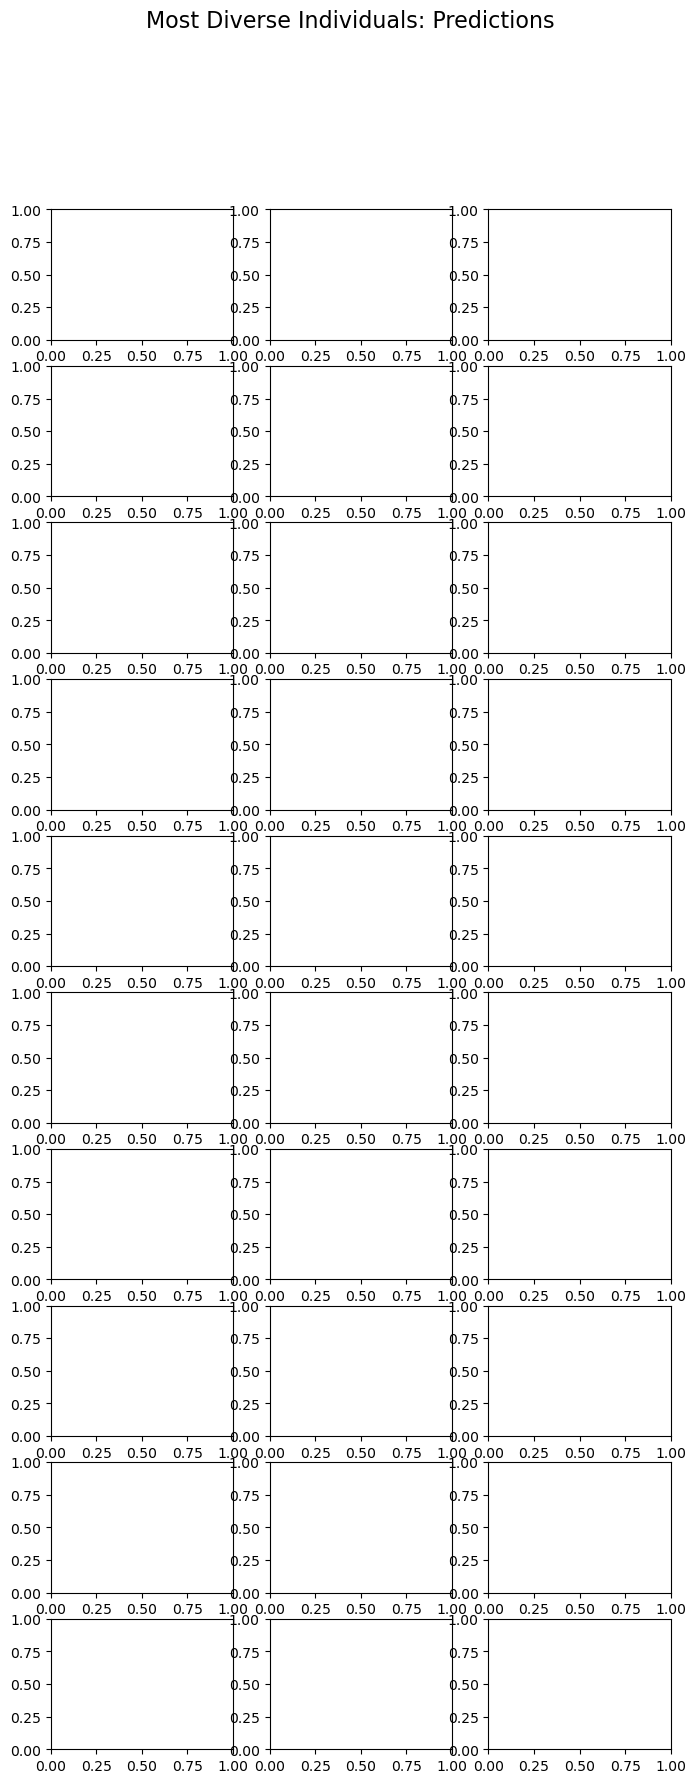

In [29]:
indiv_A, indiv_B = find_most_diverse_pair(optimizer.population)
original_val_images = X_test[:, :-1]  # remove bias term for visualization
import random

visualize_predictions_on_random_samples(X_test_exp, y_test, original_val_images, indiv_A, indiv_B, n=10)

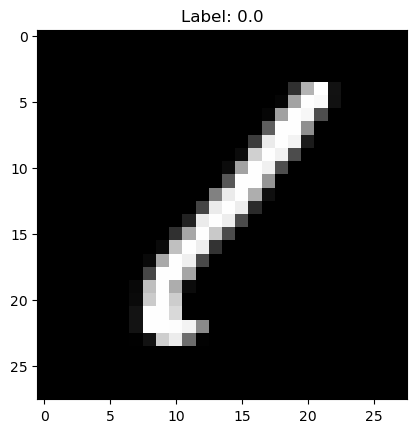

In [36]:
img = X_train[0]  # Get the first image
plt.imshow(img[:-1].view(28, 28), cmap='gray')  # Exclude the bias term (last column)
plt.title(f"Label: {y_train[0].item()}")  # Show the corresponding label
plt.show()